### NOTE JUPYTER LAB MUST BE SHUTDOWN AND ENV SWITCHED TO gpuEnv

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.features import bounds
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
# Project params

project_path = r"C:\Users\owyn\Documents\SURV509\coastal classification"
input_dir = os.path.join(project_path, "inputs")
aerial_imagery_base_dir = os.path.join(input_dir, '0.3m Aerial Imagery')
coastline_shapefile = os.path.join(input_dir, 'urban', 'intersecting_coastline.shp')

output_dir = os.path.join(project_path, "outputs")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


In [3]:
# Define paths
label_csv = os.path.join(input_dir, 'training', 'tif_labels.csv')

# Load labels
labels_df = pd.read_csv(label_csv)

# Initialize lists to store images and labels
X = []
Y = []

In [4]:
# Load images and labels
for index, row in labels_df.iterrows():
    tif_file = row['tif_file']
    label = row['label']
    
    # Load the image using rasterio
    with rasterio.open(tif_file) as src:
        image = src.read()
        
        # Convert the image to a format compatible with TensorFlow (HWC format)
        image = np.transpose(image, (1, 2, 0))  # Convert from CHW to HWC
        image = img_to_array(image)  # Convert to numpy array
        
        # Append the image and label to the lists
        X.append(image)
        Y.append(label)

In [5]:
# Convert lists to numpy arrays
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='int')

# Normalize the images
X /= 255.0

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 1985
Number of testing samples: 497


In [6]:
# Separate the images based on labels
X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]

# Baseline (dummy) accuracy
print(f"Model dummy accuracy (predicting only false) is :{X_0.shape[0]/X_train.shape[0]}")

Model dummy accuracy (predicting only false) is :0.5712846347607052


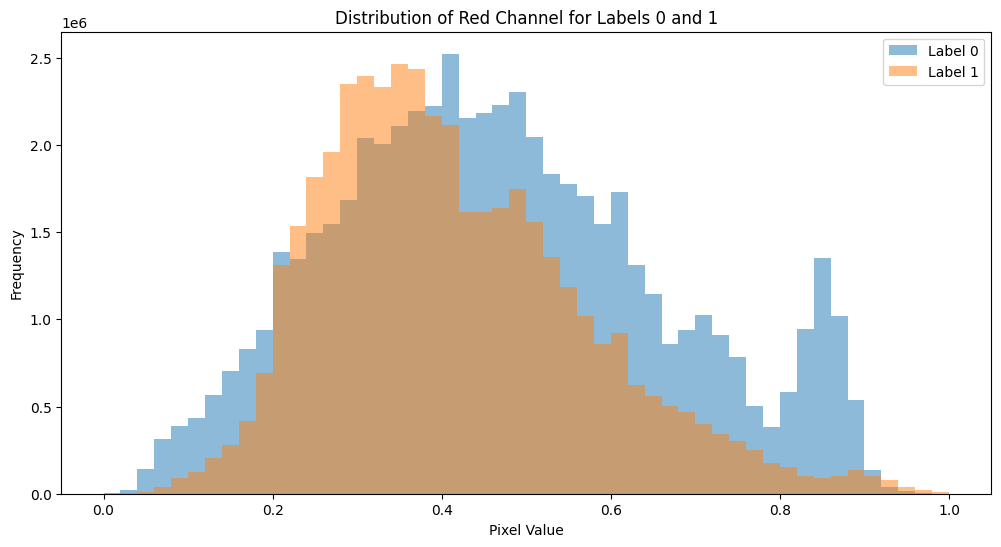

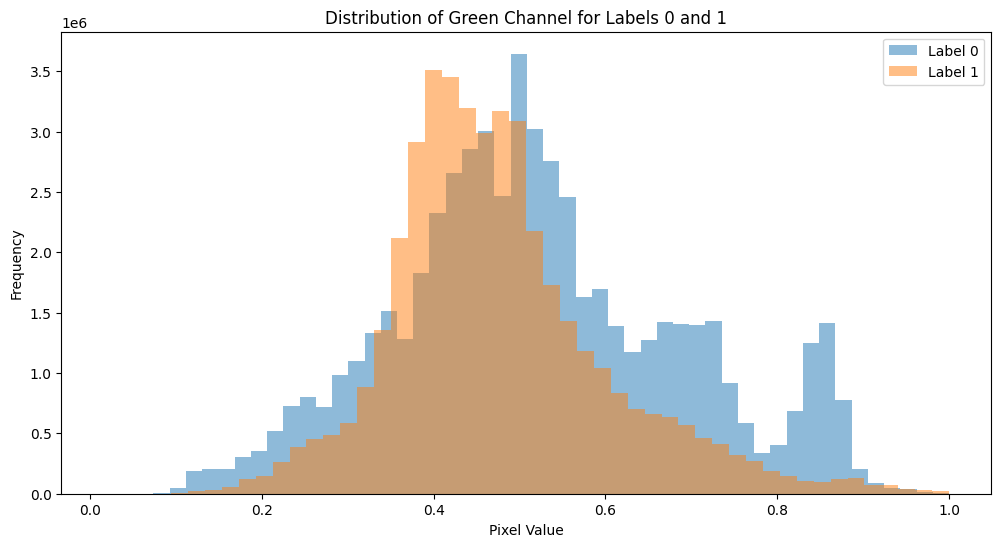

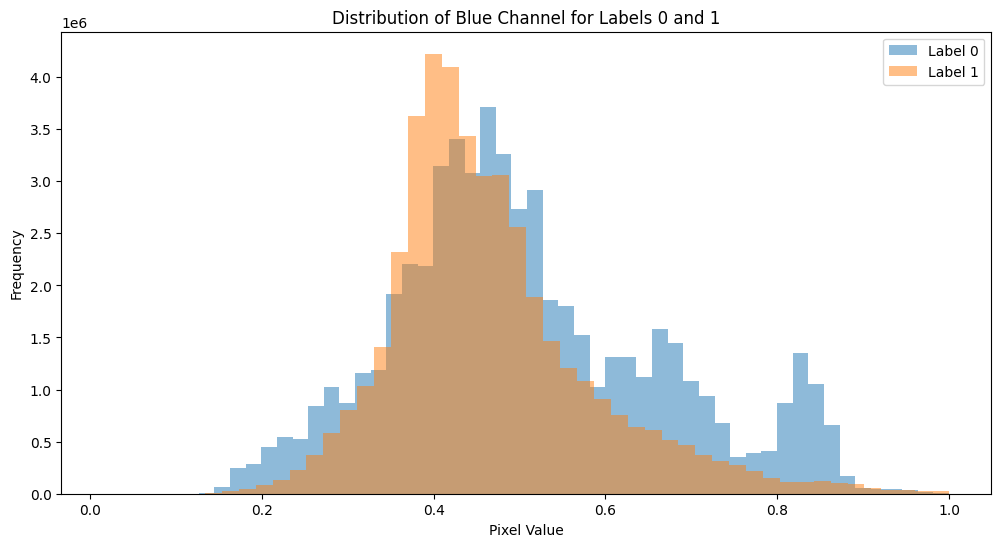

In [7]:
# Function to plot histograms
def plot_histograms(channel_data_0, channel_data_1, channel_name):
    plt.figure(figsize=(12, 6))
    plt.hist(channel_data_0, bins=50, alpha=0.5, label='Label 0')
    plt.hist(channel_data_1, bins=50, alpha=0.5, label='Label 1')
    plt.title(f'Distribution of {channel_name} Channel for Labels 0 and 1')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Extract channel data and plot histograms
for channel, channel_name in zip(range(3), ['Red', 'Green', 'Blue']):
    channel_data_0 = X_0[:, :, :, channel].ravel()
    channel_data_1 = X_1[:, :, :, channel].ravel()
    plot_histograms(channel_data_0, channel_data_1, channel_name)

## Data Augmentation

In [8]:
# Data augmentation flag
data_aug = True

if data_aug:
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        zca_epsilon=1e-06,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True
    )

    datagen.fit(X_train)
    train_data_aug = datagen.flow(X_train, Y_train)

### Basic Convolution Model

In [27]:
# Define the model
basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
basic_model._name = "basic"

### U-Net Model

In [26]:
def unet_model(input_size=(224, 224, 3)):
    inputs = Input(input_size)
    
    # Downsampling
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Upsampling
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([drop4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same')(up8)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(32, 2, activation='relu', padding='same')(up9)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    
    # Add a global average pooling layer and a dense layer for binary classification
    gap = GlobalAveragePooling2D()(conv9)
    outputs = Dense(1, activation='sigmoid')(gap)

    model = Model(inputs, outputs)

    return model

# Define the U-Net model (note batch size must be 16 to stay within vram limits (also may need more epochs + faster learning rate?)
input_size = (224, 224, 3)
unet = unet_model(input_size)
unet._name = "unet"

### Pre-trained Model

In [24]:
# Define the transfer learning model using ResNet50
def transfer_learning_model(input_size=(224, 224, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_size)
    base_model.trainable = True  # Allow fine-tuning

    # Add custom layers on top of ResNet50
    inputs = base_model.input
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

# Define the transfer learning model
input_size = (224, 224, 3)
transfer_model = transfer_learning_model(input_size)
transfer_model._name = "transfer"

In [28]:
# Compile the model
model=basic_model

# Load only weights or train model?
train_model = False
# Define the ModelCheckpoint callback
checkpoint_save_name = os.path.join(project_path,"saved_model",f"best_{model._name}_checkpoint.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_save_name,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
if train_model:
    if data_aug:
        history = model.fit(train_data_aug, epochs=20, batch_size=16,validation_data=(X_test, Y_test),
                                     callbacks=[model_checkpoint_callback])
    else:
        history = model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_test, Y_test),
                                     callbacks=[model_checkpoint_callback])

print("Loading best save weight from %s..." % checkpoint_save_name)
model.load_weights(checkpoint_save_name)
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)

Model: "basic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 128)      0     

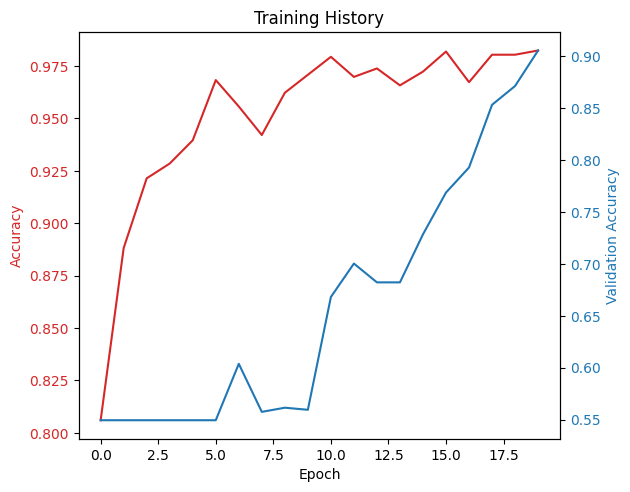

In [20]:
# Function to plot training history
def plot_history(history):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy', color='tab:red')
    ax1.plot(history['accuracy'], color='tab:red', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy', color='tab:blue')
    ax2.plot(history['val_accuracy'], color='tab:blue', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title('Training History')
    plt.show()

plot_history(history.history)

In [21]:
print(f"Test accuracy: {test_acc}")

# Summary of the labels
total_observations = len(Y)
total_ones = sum(Y)
total_zeros = total_observations - total_ones

print(f"Total number of observations: {total_observations}")
print(f"Number of 1s: {total_ones}")
print(f"Number of 0s: {total_zeros}")

# Optionally, save the labels to a CSV file
# tif_labels_df = pd.DataFrame({'tif_file': labels_df['tif_file'], 'label': Y})
# output_csv = os.path.join(input_dir, 'training', 'tif_labels.csv')
# tif_labels_df.to_csv(output_csv, index=False)
# print(f"Labels saved to {output_csv}")

Test accuracy: 0.9054325819015503
Total number of observations: 2482
Number of 1s: 1075
Number of 0s: 1407


16/16 [==============================] - 2s 59ms/step


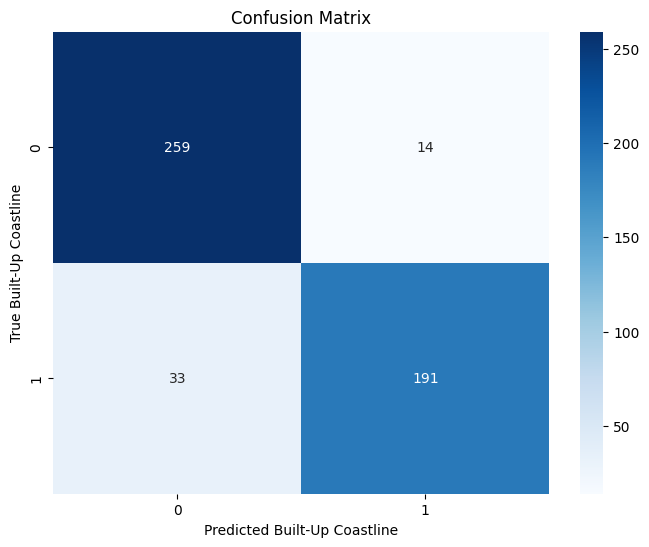

Confusion Matrix:
[[259  14]
 [ 33 191]]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype("int32")
# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Built-Up Coastline')
plt.ylabel('True Built-Up Coastline')
plt.title('Confusion Matrix')
plt.show()

print(f"Confusion Matrix:\n{conf_matrix}")


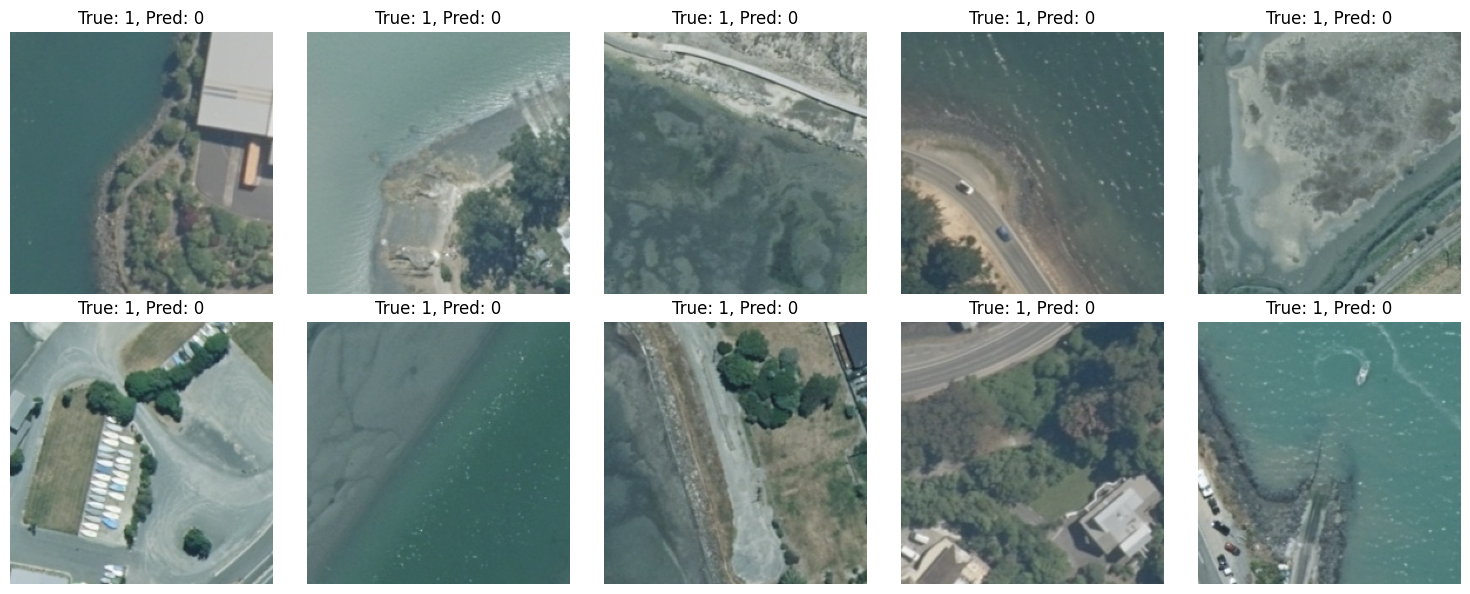

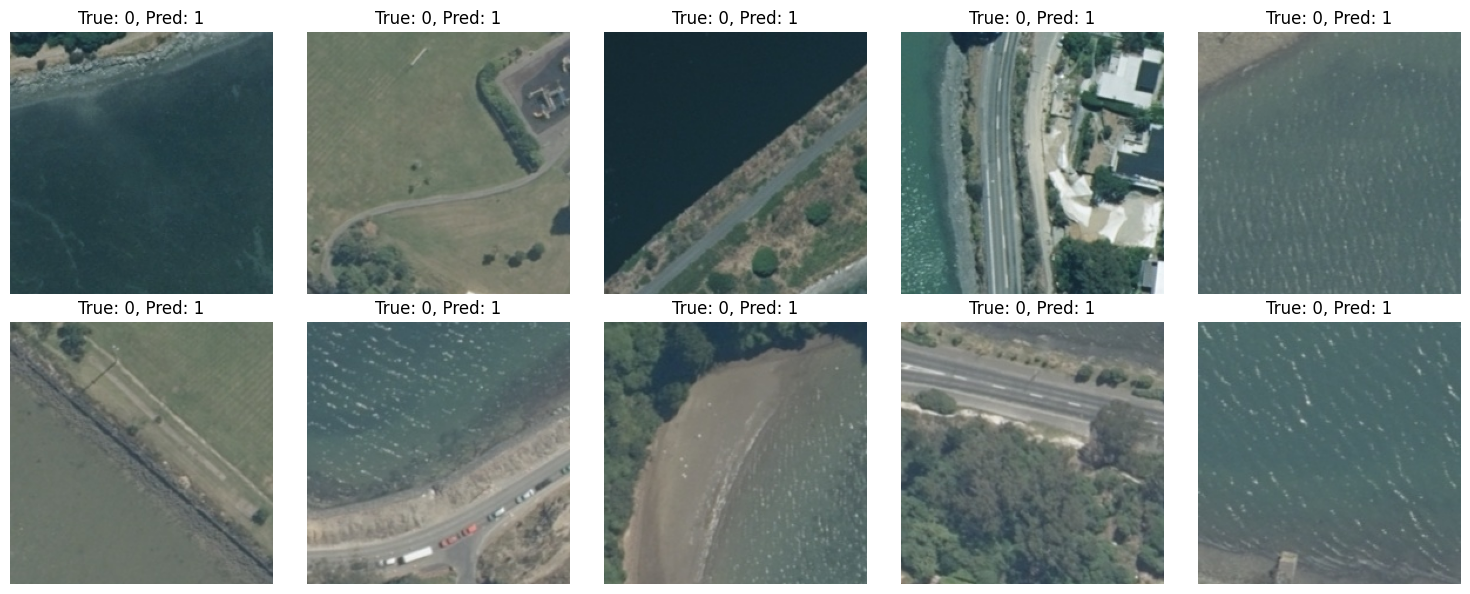

In [28]:
# Get indices of test samples where Y_test is 1 (true)
true_indices = np.where(Y_test == 1)[0]
false_indices = np.where(Y_test == 0)[0]

# Get predictions for these samples
true_predictions = Y_pred_classes[true_indices]
true_images = X_test[true_indices]

false_predictions = Y_pred_classes[false_indices]
false_images = X_test[false_indices]

# Find correct and incorrect predictions
false_neg_indices = [i for i, pred in zip(true_indices, true_predictions) if pred == 0][:10]
false_pos_indices = [i for i, pred in zip(false_indices, false_predictions) if pred == 1][:10]

# Function to display images
def display_images(images, titles, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))
    axes = axes.flatten()
    for img, ax, title in zip(images, axes, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 false negative predictions
false_neg_images = X_test[false_neg_indices]
false_neg_titles = [f"True: 1, Pred: 0" for _ in false_neg_indices]
display_images(false_neg_images, false_neg_titles, nrows=2, ncols=5)

# Display 10 false positive predictions
false_pos_images = X_test[false_pos_indices]
false_pos_titles = [f"True: 0, Pred: 1" for _ in false_pos_indices]
display_images(false_pos_images, false_pos_titles, nrows=2, ncols=5)


# Running the model across the dataset

In [32]:
# Function to process TIFF files and save bounding boxes for predictions with label 1
def process_and_save_bounding_boxes(region_name, model, input_dir=input_dir, output_dir=output_dir):
    region_dir = os.path.join(input_dir, '0.3m Aerial Imagery', region_name, 'retiled')
    output_region_dir = os.path.join(output_dir, region_name)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_region_dir, exist_ok=True)
    
    # Initialize lists to store images and corresponding bounding boxes
    X = []
    bounding_boxes = []
    tif_files = glob.glob(os.path.join(region_dir, '*.tif'))
    # Iterate over TIFF files in the region directory
    for tif in tif_files:
        with rasterio.open(tif) as src:
            image = src.read()
            
            # Convert the image to a format compatible with TensorFlow (HWC format)
            image = np.transpose(image, (1, 2, 0))  # Convert from CHW to HWC
            image = img_to_array(image)  # Convert to numpy array
            
            # Append the image and bounding box to the lists
            X.append(image)
            bounding_boxes.append(box(*src.bounds))
    # Convert list to numpy array
    X = np.array(X, dtype='float32')
    
    # Normalize the images
    X /= 255.0
    # Make predictions
    Y_pred = model.predict(X)
    Y_pred_classes = (Y_pred > 0.5).astype("int32")
    # Filter bounding boxes where the prediction is 1
    valid_bounding_boxes = [bounding_boxes[i] for i in range(len(Y_pred_classes)) if Y_pred_classes[i] == 1]
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': valid_bounding_boxes}, crs='EPSG:2193')
    
    # Save the bounding boxes as a shapefile
    output_shapefile = os.path.join(output_region_dir, 'predicted_bounding_boxes.shp')
    gdf.to_file(output_shapefile)
    
    print(f"Bounding boxes saved to {output_shapefile}")

# Function to create a layer showing sections of the coastline contained by bounding boxes
def create_coastline_layer(region_name, coastline_shapefile, input_dir=output_dir, output_dir=output_dir):
    input_region_dir = os.path.join(input_dir, region_name)
    output_region_dir = os.path.join(output_dir, region_name)
    
    # Load the bounding boxes shapefile
    bounding_boxes_shapefile = os.path.join(input_region_dir, 'predicted_bounding_boxes.shp')
    bounding_boxes_gdf = gpd.read_file(bounding_boxes_shapefile)
    
    # Load the coastline shapefile
    coastline_gdf = gpd.read_file(coastline_shapefile)
    
    # Find the intersection of the coastline with the bounding boxes
    intersecting_coastline = gpd.overlay(coastline_gdf, bounding_boxes_gdf, how='intersection')
    
    # Save the intersecting coastline segments to a new shapefile
    output_coastline_shapefile = os.path.join(output_region_dir, 'intersecting_coastline.shp')
    intersecting_coastline.to_file(output_coastline_shapefile)
    
    print(f"Intersecting coastline shapefile created at {output_coastline_shapefile}")

for region_name in os.listdir(aerial_imagery_base_dir):
    region_dir = os.path.join(aerial_imagery_base_dir, region_name)
    if os.path.isdir(region_dir):
        print(region_name)
        process_and_save_bounding_boxes(region_name, model)
        create_coastline_layer(region_name, coastline_shapefile)

christchurch
32/32 [==============================] - 2s 62ms/step
Bounding boxes saved to C:\Users\owyn\Documents\SURV509\coastal classification\outputs\christchurch\predicted_bounding_boxes.shp
Intersecting coastline shapefile created at C:\Users\owyn\Documents\SURV509\coastal classification\outputs\christchurch\intersecting_coastline.shp
dunedin
47/47 [==============================] - 3s 64ms/step
Bounding boxes saved to C:\Users\owyn\Documents\SURV509\coastal classification\outputs\dunedin\predicted_bounding_boxes.shp
Intersecting coastline shapefile created at C:\Users\owyn\Documents\SURV509\coastal classification\outputs\dunedin\intersecting_coastline.shp
greymouth
10/10 [==============================] - 1s 62ms/step
Bounding boxes saved to C:\Users\owyn\Documents\SURV509\coastal classification\outputs\greymouth\predicted_bounding_boxes.shp
Intersecting coastline shapefile created at C:\Users\owyn\Documents\SURV509\coastal classification\outputs\greymouth\intersecting_coastline

C:\Users\owyn\miniforge3\envs\gpuEnv\lib\site-packages\geopandas\io\file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
C:\Users\owyn\miniforge3\envs\gpuEnv\lib\site-packages\geopandas\io\file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
